# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [2]:
# импортируем библиотеки, необходимые для выполнения основных заданий
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import resample

import catboost

In [3]:
# зададим стиль для графиков seaborn
sns.set(style="darkgrid", rc={'figure.figsize':(9, 7.5)}, font_scale=1.25)

In [4]:
# открываем файл, читаем содержимое
file_path = '/datasets/users_behavior.csv'
try:
    clients_df = pd.read_csv(f'.{file_path}')  # путь на локальном компьютере
except FileNotFoundError:
    clients_df = pd.read_csv(file_path)  # путь на сервере

In [5]:
# смотрим случайные 5 строчек датасета
clients_df.sample(5)

,calls,minutes,messages,mb_used,is_ultra
64,67.0,390.62,99.0,12991.39,0
1610,78.0,566.45,38.0,17971.00,1
1857,62.0,352.66,82.0,28205.37,0
149,74.0,455.73,99.0,21694.92,0
2577,15.0,128.91,6.0,2241.43,1


In [6]:
# выводим основную информацию по датасету
clients_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [7]:
# выведем явно число пропусков в каждой колонке
clients_df.isna().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

Имеется 4 числовых признака и один категориальный, который автоматически был преобразован к типу `int64`. Всего в датасете 5 колонок и 3214 строк. Пропусков в данных нет (что не удивительно, ведь мы уже ранее сделали предобработку).

In [8]:
print("Уникальные элементы в колонке 'is_ultra':", clients_df.is_ultra.unique())

Уникальные элементы в колонке 'is_ultra': [0 1]


In [9]:
# приведем тип колонки is_ultra к категориальной
clients_df.is_ultra = clients_df.is_ultra.astype('category')

In [10]:
# посмотрим основную описательную статистику по числовым признакам
display(clients_df.describe())
# по категориальным
clients_df.describe(include='category')

,calls,minutes,messages,mb_used
count,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836
std,33.236368,234.569872,36.148326,7570.968246
min,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500
50%,62.000000,430.600000,30.000000,16943.235000
75%,82.000000,571.927500,57.000000,21424.700000
max,244.000000,1632.060000,224.000000,49745.730000


,is_ultra
count,3214
unique,2
top,0
freq,2229


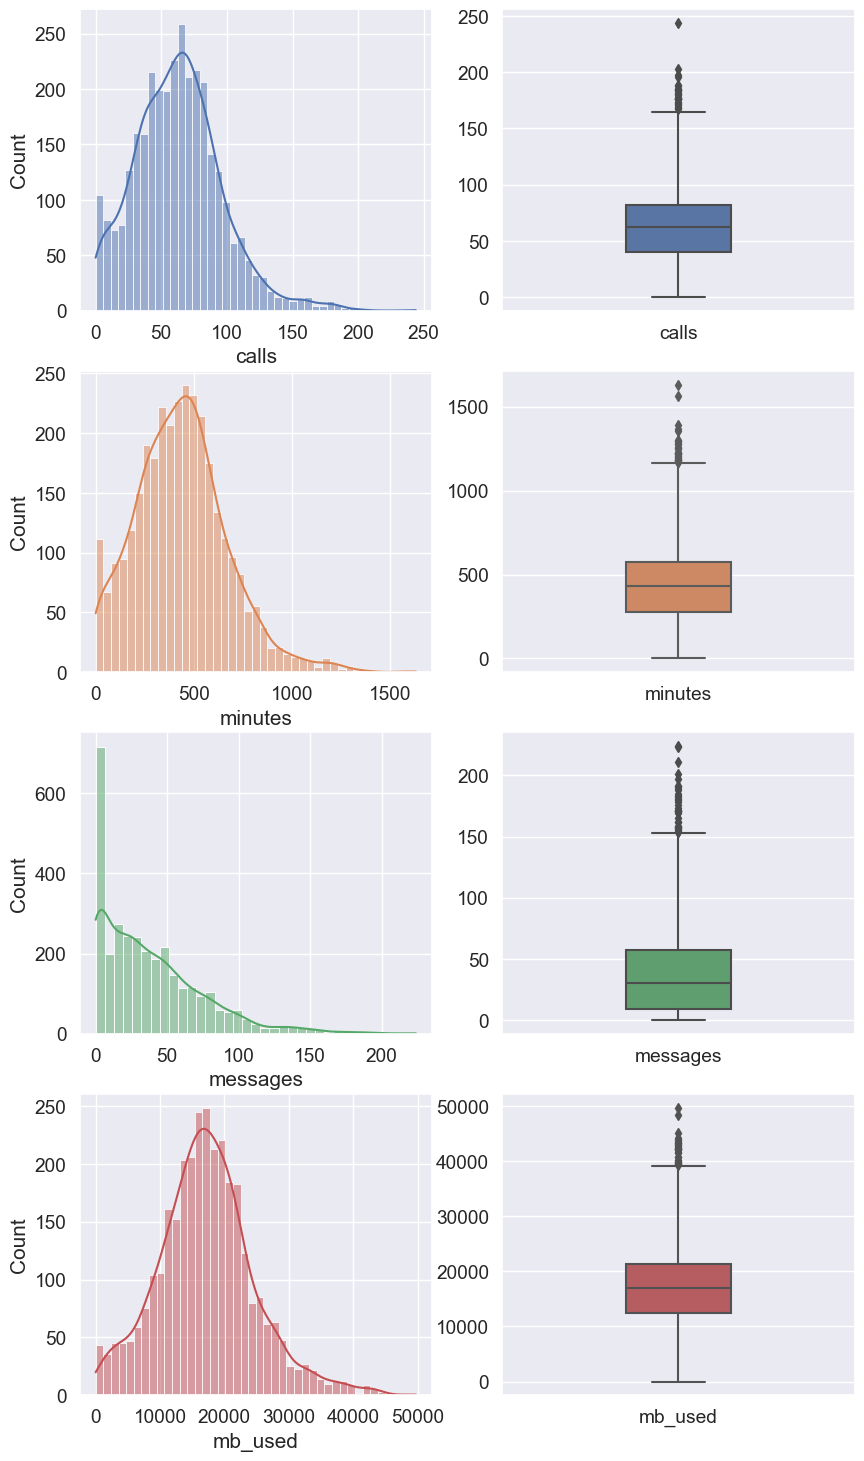

In [11]:
# построим гистограммы и "ящики с усами" для числовых признаков 

# выберем колонки только с числовыми признками
numeric_cols = clients_df.select_dtypes(include='number').columns

# зададим размер сетки для построения графиков
fig, axes = plt.subplots(numeric_cols.size, 2, figsize=(10,18))

# цвета для раскрашивания графиков
colors = iter(sns.color_palette('deep'))

for i, col in enumerate(numeric_cols):
    color = next(colors)
    ax_hist = sns.histplot(data=clients_df[col], ax=axes[i][0], color=color, kde=True)
    
    ax_box = sns.boxplot(data=clients_df[col], ax=axes[i][1], color=color, width=0.3, whis=2)
    ax_box.set_xticklabels([col])
plt.show()

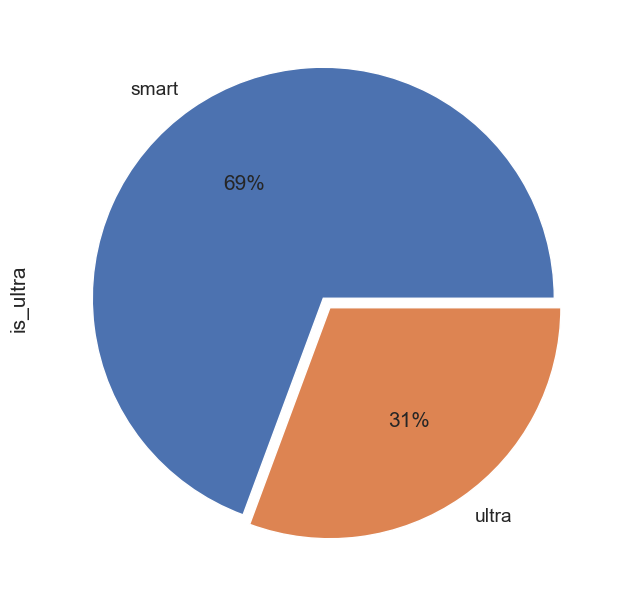

In [12]:
# построим круговую диаграмму для категориального признака
values = clients_df.is_ultra.value_counts()
values = values.rename(index={0: 'smart', 1: 'ultra'})

values.plot.pie(autopct='%.0f%%', explode=[0,0.05]);

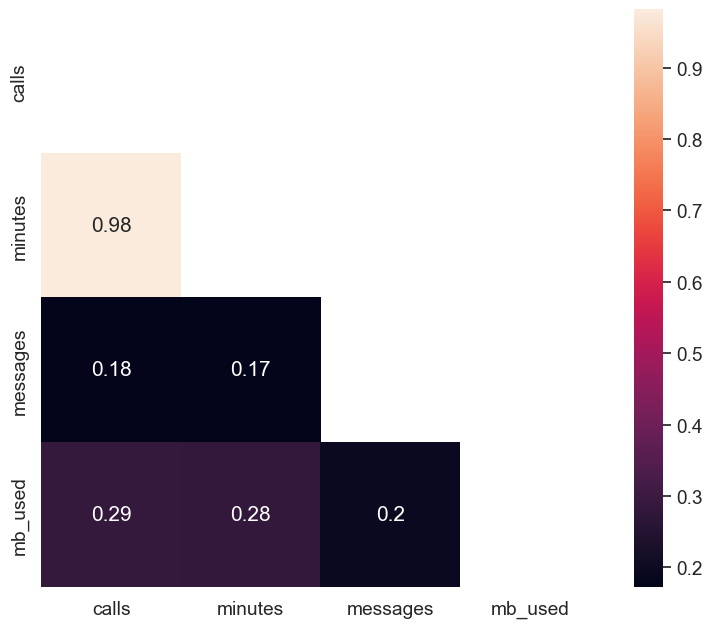

In [13]:
# построим таблицу корреляций численных признаков

# маска для заполнения верхнего треугольника матрицы единицами
mask = np.zeros_like(clients_df.corr())
triangle = np.triu_indices_from(mask)
mask[triangle] = True

# построение хитмапа со значениями корреляций
sns.set_style('white')
sns.heatmap(clients_df.corr(), mask=mask, annot=True);

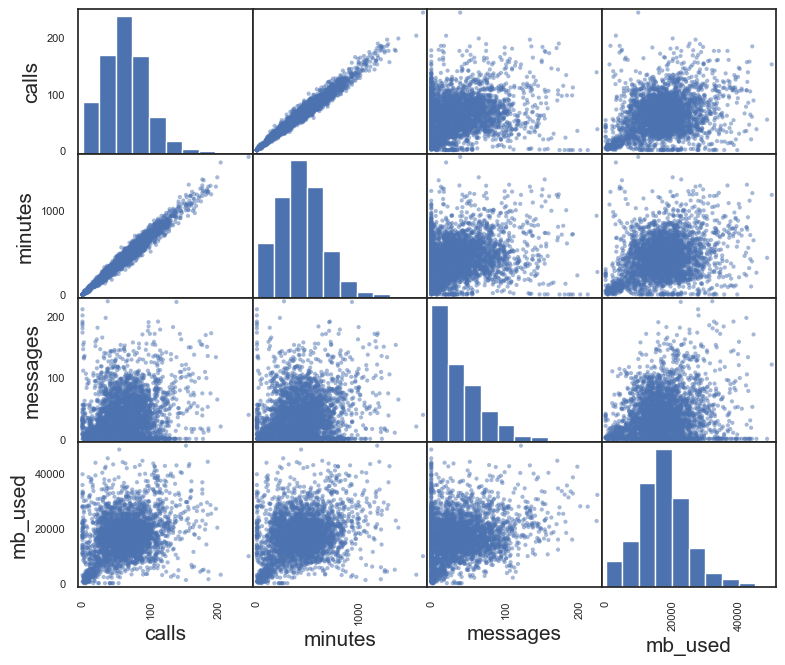

In [14]:
# также визуализируем зависимости
pd.plotting.scatter_matrix(clients_df);

**Основные выводы по данным**:
- Все данные почищены и приведены к необходимым типам;
- Численные выборки имеют распределения, близкие к Пуассоновскому;
- Имеется несбалансированность целевой переменной smart:ultra - 69:31, может так произойти, что обученная модель будет склоняться к варианту `smart`, который представлен в большей степени;
- Наблюдается сильная корреляция между признаками `calls` и `minutes`, слабая корреляция в парах `mb_used`/`calls` и `mb_used`/`minutes`. 

## Разбейте данные на выборки

Формально разбиение на три подвыборки (обучающую, валидационную и тестовую) можно проделать следующим способом.

In [15]:
# разделим выборки на обучающую, валидационную и тестовую части с соотношениями 3:1:1
X = clients_df.drop('is_ultra', axis=1)  # обучающая выборка
y = clients_df.is_ultra  # целевая переменная

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)  # 20% данных на тестовую часть

# ещё 20% на валидационную, 0.8 * 0.25 = 0.2
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=101, test_size=0.25)

In [16]:
print(f"Соотношения выборок train/valid/test: {X_train.size/X.size:.1f}/{X_valid.size/X.size:.1f}/{X_test.size/X.size:.1f}")

Соотношения выборок train/valid/test: 0.6/0.2/0.2


Однако при обучении моделей и поиске оптимальных гиперпараметров мы будем использовать ***кросс-валидацию***: в процессе обучения выборка будет разбиваться на заданное число подвыборок `cv` (фолдов), одна из которых будет являться валидационной, а остальные обучающими. Для каждой комбинации гиперпараметров (которые мы будем варьировать) по очереди один из фолдов будет задаваться как "валидационный", а обучение будет происходить на оставшихся. В конце мы получим среднюю метрику по всем валидационным подвыборкам.

![cross_validation.png](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

Соответственно, разделим начальную выборку только на две части с соотношением 3:1.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

## Исследуйте модели

In [18]:
# создадим функцию, в которую можно будет передавать обучающие данные и модель с сеткой гиперпараметров
# которая будет искать их оптимальную комбинацию

def search_optimal_hyperparameters(X, y, model, grid_parameters, cv=5, scoring='accuracy'):
    
    # поиск по сетке значений гиперпараметров
    CV_model = GridSearchCV(
        estimator=model,
        param_grid=grid_parameters,
        cv=cv,      # разбиение на фолды
        scoring=scoring,
        refit=True, # в конце выбираем модель с лучшими гиперпараметрами
        verbose=10, # вывести некоторую информацию по обучению
        n_jobs=-1,  # используем все доступные ядра процессора
    )
    
    CV_model.fit(X, y)  # обучаем модель

    return CV_model

### Решающее дерево

Поскольку у нас относительно мало данных, а решающие деревья обучаются быстро, можем себе позволить использовать достаточно большую сетку гиперпараметров.

In [19]:
%%time
# смотрим, сколько времени заняло обучение

# задаем сетку с различными значениями гиперпараметров решающего дерева
parameters = {
    'max_depth': list(range(2, 21, 1)),         # максимальная глубина решающего дерева
    'max_leaf_nodes': list(range(12, 20, 1)),   # максимальное число листьев в дереве
    'min_samples_leaf': list(range(1, 10, 2)),  # минимальное число объектов в листе
    'min_samples_split': list(range(2, 11, 2)), # минимальное количество элементов в вершине, чтобы её можно было делить
    'criterion': ['gini', 'entropy'],           # функция измерения качества разбиения подвыборки
}

dtree_cv = search_optimal_hyperparameters(X_train, y_train, DecisionTreeClassifier(), parameters)

Fitting 5 folds for each of 7600 candidates, totalling 38000 fits
CPU times: total: 14.3 s
Wall time: 49 s


In [20]:
# выведем модель с оптимальными гиперпараметрами
dtree_cv.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=9, max_leaf_nodes=16)

Можно заметить, что для модели указываются только значения для параметров `criterion`, `max_depth` и `max_leaf_nodes`. Это связано с тем, что для остальных параметров оптимальные значения оказались равными дефолтным.

In [21]:
print("Лучшее 'accuracy' для решающего дерева:", dtree_cv.best_score_)

Лучшее 'accuracy' для решающего дерева: 0.7987551867219918


### Случайный лес

Поскольку случайный лес обучается гораздо дольше, чем одно решающее дерево, будем варьировать гиперпараметры вблизи оптимальных для одного решающего дерева, которые мы получили на предыдущем шаге.

In [22]:
%%time

parameters = {
    'n_estimators': [10, 50, 100, 200],          # число решающих деревьев
    'max_depth': list(range(7, 12)),
    'max_leaf_nodes': list(range(13, 19, 1)),
    'criterion': ['entropy'], 
}

rforest_cv = search_optimal_hyperparameters(X_train, y_train, RandomForestClassifier(), parameters)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
CPU times: total: 1.72 s
Wall time: 25.5 s


In [23]:
# выведем модель с оптимальными гиперпараметрами
rforest_cv.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=9, max_leaf_nodes=18)

In [24]:
print("Лучшее 'accuracy' для случайного леса:", rforest_cv.best_score_)

Лучшее 'accuracy' для случайного леса: 0.8053941908713693


### Логистическая регрессия

In [25]:
%%time

parameters = {
    'C': np.linspace(0.01, 10, 201),  # коэффициент перед регуляризационным членом
    'penalty': ['l1', 'l2'],         # тип регуляризации (через манхэттоновское расстояние или Тихонова)
    'solver': ['liblinear', 'saga']  # алгоритм оптимизации
}

log_reg_cv = search_optimal_hyperparameters(X_train, y_train, LogisticRegression(), parameters)

Fitting 5 folds for each of 804 candidates, totalling 4020 fits
CPU times: total: 2.55 s
Wall time: 11.1 s


In [26]:
# выведем модель с оптимальными гиперпараметрами
log_reg_cv.best_estimator_

LogisticRegression(C=2.6573499999999997, penalty='l1', solver='liblinear')

In [27]:
print("Лучшее 'accuracy' для логистической регрессии:", log_reg_cv.best_score_)

Лучшее 'accuracy' для логистической регрессии: 0.7452282157676349


### Градиентный бустинг

Используем градиентный бустинг деревьев решений. Метод заключается в том, что берется ансамбль деревьев решений и обучается последовательно. На каждой итерации вычисляются отклонения предсказаний уже обученного ансамбля на обучающей выборке. Следующая модель, которая будет добавлена в ансамбль будет предсказывать эти отклонения.

Как правило, градиентный бустинг позволяет добиться хороших результатов без "лишних хлопот".

In [28]:
boosting_model = catboost.CatBoostClassifier(eval_metric='Accuracy',
                                             silent=True,
                                             random_state=42)

# проведем только кросс-валидацию, менять гиперпараметры не будем
boosting_model.grid_search({}, X_train, y_train, refit=True, cv=5)


bestTest = 0.8029045643
bestIteration = 286

0:	loss: 0.8029046	best: 0.8029046 (0)	total: 3.52s	remaining: 0us
Estimating final quality...
Training on fold [0/5]

bestTest = 0.8074534161
bestIteration = 66

Training on fold [1/5]

bestTest = 0.8112033195
bestIteration = 147

Training on fold [2/5]

bestTest = 0.8360995851
bestIteration = 129

Training on fold [3/5]

bestTest = 0.8298755187
bestIteration = 570

Training on fold [4/5]

bestTest = 0.8004158004
bestIteration = 345



{'params': {},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
               48,
               49

In [29]:
print("Лучшее 'accuracy' для градиентного бустинга:", boosting_model.best_score_['learn']['Accuracy'])

Лучшее 'accuracy' для градиентного бустинга: 0.870954356846473


## Проверьте модель на тестовой выборке

In [30]:
print("Значение 'accuracy' на тестовой выборке для")
print(f'Решающего дерева:{dtree_cv.score(X_test, y_test):>14.3f}')
print(f'Случайного леса:{rforest_cv.score(X_test, y_test):>15.3f}')
print(f'Логистической регрессии:{log_reg_cv.score(X_test, y_test):>7.3f}')
print(f'Градиентного бустинга: {boosting_model.score(X_test, y_test):>8.3f}')

Значение 'accuracy' на тестовой выборке для
Решающего дерева:         0.807
Случайного леса:          0.813
Логистической регрессии:  0.755
Градиентного бустинга:    0.828


На тестовой выборке наилучшее значение метрики `accuracy` имеет модель градиентного бустинга.

## (бонус) Проверьте модели на адекватность

Основная проблема метрики `accuracy` состоит в том, что она плоха для несбалансированных данных, т.е. когда одного класса существенно больше, чем другого. Допустим, если в целевой переменной есть два класса, в которых имеется 800 элементов `1` и 200 элементов `0`, то `accuracy` для модели, которая всегда выдает `1`, на этих данных будет 0.8. Хорошее значение метрики но модель явно неадекватна.

В нашем случае в целевой переменной также есть несбалансированность, поэтому все модели обязательно требуется проверить на адекватность. Для этого воспользуемся метриками `precision`, `recall`, `f1-score`.

In [31]:
# решающее дерево
print(classification_report(y_test, dtree_cv.predict(X_test), target_names=['smart', 'ultra']))

              precision    recall  f1-score   support

       smart       0.82      0.93      0.87       565
       ultra       0.76      0.52      0.62       239

    accuracy                           0.81       804
   macro avg       0.79      0.72      0.74       804
weighted avg       0.80      0.81      0.80       804



Точность модели (precision): в 82% случаев правильно предсказывает клиентов с тарифом `smart`, в 76% - с тарифом `ultra`. Если в тестовом наборе имеются клиенты с тарифом `ultra`, то модель правильно предсказывает их в 52% случаев.

Выведем таблицу также для остальных моделей.

In [32]:
# случайный лес
print(classification_report(y_test, rforest_cv.predict(X_test), target_names=['smart', 'ultra']))

              precision    recall  f1-score   support

       smart       0.82      0.94      0.88       565
       ultra       0.79      0.51      0.62       239

    accuracy                           0.81       804
   macro avg       0.80      0.73      0.75       804
weighted avg       0.81      0.81      0.80       804



In [33]:
# логистическая регрессия
print(classification_report(y_test, log_reg_cv.predict(X_test), target_names=['smart', 'ultra']))

              precision    recall  f1-score   support

       smart       0.75      0.97      0.85       565
       ultra       0.78      0.25      0.37       239

    accuracy                           0.75       804
   macro avg       0.76      0.61      0.61       804
weighted avg       0.76      0.75      0.71       804



In [34]:
# градиентный бустинг
print(classification_report(y_test, boosting_model.predict(X_test), target_names=['smart', 'ultra']))

              precision    recall  f1-score   support

       smart       0.84      0.94      0.89       565
       ultra       0.80      0.56      0.66       239

    accuracy                           0.83       804
   macro avg       0.82      0.75      0.77       804
weighted avg       0.83      0.83      0.82       804



Сравнивая полученные результаты по метрике `f1` (среднее гармоническое метрик `Precision` и `Recall`) получаем, что модели на основе решающих деревьев дают лучший результат и лишь немного отличаются друг от друга, в то время как логистическая регрессия получилась неадекватной.

## Балансировка выборки

In [35]:
# попробуем сбалансировать выборку

# выделим две части выборки по значению в целевой переменной
df_majority = clients_df[clients_df.is_ultra==0]
df_minority = clients_df[clients_df.is_ultra==1]

# увеличиваем число строк в датафрейме с меньшим числом записей за счет случайного дублирования
df_minority_upsampled = resample(df_minority, 
                                 n_samples=2229,    # число строк в df_majority
                                 random_state=123)              

df_upsampled = pd.concat([df_majority, df_minority_upsampled]) # собираем всё в единый датафрейм

In [36]:
# подсчитаем число значений 0 и 1 в колонке is_ultra
df_upsampled.is_ultra.value_counts()

0    2229
1    2229
Name: is_ultra, dtype: int64

In [37]:
# разобьем данные на признаки и целевую переменную
X_upsampled = df_upsampled.drop('is_ultra', axis=1)
y_upsampled = df_upsampled.is_ultra

In [38]:
# выделим обучающую выборку и тестовую
X_train_upsampled, X_test_upsampled, y_train_upsampled, y_test_upsampled = train_test_split(
    X_upsampled, y_upsampled, random_state=101, test_size=0.25)

In [39]:
# используем градиентный бустинг и кросс валидацию
boosting = catboost.CatBoostClassifier(eval_metric='Accuracy')
boosting.grid_search({}, X_train_upsampled, y_train_upsampled, cv=5)

0:	learn: 0.7251309	test: 0.6965620	best: 0.6965620 (0)	total: 2.56ms	remaining: 2.56s
1:	learn: 0.7400898	test: 0.7100149	best: 0.7100149 (1)	total: 5.03ms	remaining: 2.51s
2:	learn: 0.7554226	test: 0.7294469	best: 0.7294469 (2)	total: 7.33ms	remaining: 2.44s
3:	learn: 0.7486911	test: 0.7279522	best: 0.7294469 (2)	total: 9.63ms	remaining: 2.4s
4:	learn: 0.7464473	test: 0.7339312	best: 0.7339312 (4)	total: 11.9ms	remaining: 2.36s
5:	learn: 0.7486911	test: 0.7399103	best: 0.7399103 (5)	total: 14.4ms	remaining: 2.38s
6:	learn: 0.7524308	test: 0.7443946	best: 0.7443946 (6)	total: 16.9ms	remaining: 2.4s
7:	learn: 0.7595363	test: 0.7428999	best: 0.7443946 (6)	total: 19.4ms	remaining: 2.4s
8:	learn: 0.7528048	test: 0.7443946	best: 0.7443946 (6)	total: 21.8ms	remaining: 2.4s
9:	learn: 0.7587883	test: 0.7428999	best: 0.7443946 (6)	total: 24.3ms	remaining: 2.4s
10:	learn: 0.7498130	test: 0.7414051	best: 0.7443946 (6)	total: 26.7ms	remaining: 2.4s
11:	learn: 0.7509349	test: 0.7458894	best: 0.745

{'params': {},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
               48,
               49

In [40]:
# выводим основные метрики
print(classification_report(y_test_upsampled, boosting_model.predict(X_test_upsampled), target_names=['smart', 'ultra']))

              precision    recall  f1-score   support

       smart       0.71      0.97      0.82       560
       ultra       0.95      0.60      0.74       555

    accuracy                           0.79      1115
   macro avg       0.83      0.78      0.78      1115
weighted avg       0.83      0.79      0.78      1115



Видим, что итоговое значение `accuracy` уменьшилось, однако мы смогли улучшить парметры `precision` и `recall` для предсказаний `ultra`, при этом показатели для определения `smart` немного уменьшились.

# Вывод

- проведен первичный анализ данных, определено, что
    - численные выборки имеют распределения, близкие к Пуассоновскому;
    - имеется несбалансированность целевой переменной smart:ultra - 69:31;
    - имеется сильная корреляция между признаками calls и minutes, слабая корреляция в парах mb_used/calls и mb_used/minutes.
- проведено разбиение данных на обучающую и тестовую части. Валидация при обучении проводилась с использованием кросс-валидации;
- для обучения использовались четыре модели: решающее дерево, случайный лес, логистическая регрессия и градиентный бустинг;
- на тестовой выборке наибольшее значение `accuracy` было получено для градиентного бустинга; хуже всего себя показала модель логистической регрессии;
- проверка моделей на адекватность показала, что у всех имеются проблемы с правильным определением клиентов с тарифом `ultra`, при этом модель логистической регрессии получилась неадекватной;
- в попытке улучшить адекватность модели градиентного бустинга, была проведена балансировка выборки. Удалось достигнуть некоторых успехов, однка `accuracy` снизилась относительно первоначального варианта.